In [30]:
import torch
import pandas as pd
import numpy as np
import random
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [13]:
# # Create customzied dataset
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, df):
#         self.df = df
#     def __len__(self):
#         return len(self.df)
#     def __getitem__(self, idx):
#         input_values, labels = self.df[['input_values', 'score']].iloc[idx]
#         return dict(
#             input_values = torch.tensor(input_values),
#             labels = torch.tensor(labels).float(),
#         )

In [102]:
# Load dataset
df = pd.read_csv("../data_collection/sentiment_data.csv")
df = df.dropna()
df['score'] = df['score'].apply(lambda x: x + 1)
df.head()


,text,score
0,no problem i will send you the information sho...,2
1,maybe i give you a call back. do you prefer to...,1
2,okay thank you so much for your time.,2
3,then okay i will call again on tuesday bye bye.,1
4,sure I can call you back on next tuesday. than...,2


In [196]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("Souvikcmsa/SentimentAnalysisDistillBERT")
# Load auto tokenizer
tokenizer = AutoTokenizer.from_pretrained("Souvikcmsa/SentimentAnalysisDistillBERT")

In [252]:
# Split dataset
train_text, test_text, train_label, test_label = train_test_split(df['text'], df['score'], test_size = 0.33, random_state = 1070, stratify = df['score'])

In [253]:
train_text

14                                           I hate you
12    as a result of that insurance company actually...
2                 okay thank you so much for your time.
33            has anyone from us or a broker quoted you
6     ya hello good afternoon speak to leon please. ...
3       then okay i will call again on tuesday bye bye.
30    may I put you on hold while I check with my su...
1     maybe i give you a call back. do you prefer to...
7     ya you see even just now he message me he said...
9     good evening may i speak to mister leon please...
27    it can protect yourself and your baby right al...
20    okay very dangerous a lot of people actually g...
0     no problem i will send you the information sho...
26    I will definitely send you a brouchure then ca...
24    now third party liability means touch wood in ...
4     sure I can call you back on next tuesday. than...
32      may I proceed to help you with the purchase now
25    so they will definitely sue you for the da

In [254]:
test_text

8     currently we partnership with abcd. can i chec...
13                         i dont want to talk with you
18    if fully paid you must have some form of cover...
17                     okay your home is hdb or private
11    ya hello good afternoon speak to nanny seah pl...
16    if you don’t mind me asking have you bought a ...
28    as long as children below twenty five years ol...
29    usually financially dependent on parents right...
10    thank you for calling income. this is leon how...
19    once they pay okay you are not really required...
23    then most important is the reason main reason ...
31                       thank you for holding the line
Name: text, dtype: object

<AxesSubplot:>

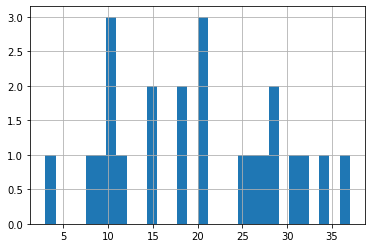

In [255]:
# Tokenization
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [256]:
max_length = 40

In [257]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_length,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [258]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_label.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

In [259]:
# Create data loader

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [260]:
# Only freeze transformer part parameters
for name, param in model.named_parameters():
    if name != "pre_classifier.weight" and name != "pre_classifier.bias" and name != "classifier.weight" and name != "classifier.bias":
        param.requires_grad = False
    else:
        print(name, "not freezed")
        print(param.requires_grad)

pre_classifier.weight not freezed
True
pre_classifier.bias not freezed
True
classifier.weight not freezed
True
classifier.bias not freezed
True


In [261]:
class disbert_arch(nn.Module):
    def __init__(self, model):
        super(disbert_arch, self).__init__()
        self.disbert = model
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, sent_id, mask):
        x = self.disbert(sent_id, attention_mask = mask).logits
        x = self.softmax(x)
        return x

In [262]:
new_model = disbert_arch(model)

In [263]:
# optimizer from huggingface transformers
from transformers import AdamW
optimizer = AdamW(new_model.parameters(), lr = 1e-3)

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [264]:
# Find Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight(class_weight = 'balanced',
                                 classes = np.unique(train_label),
                                 y = train_label)
print(class_wts)

[3.83333333 0.63888889 0.85185185]


In [265]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype = torch.float)

# Loss function
cross_entropy = nn.NLLLoss(weight = weights)


In [266]:
# Fine Tune Distil Bert
# function to train the model
def train(model, train_dataloader = train_dataloader):

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        #batch = [r.to(device) for r in batch]
        batch = [r for r in batch]
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        print(loss)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        preds = preds.detach().numpy()
        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        # preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [267]:
# function for evaluating the model
def evaluate(model, val_dataloader = test_dataloader):
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        # batch = [t.to(device) for t in batch]
        batch = [t for t in batch]
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [269]:
# set initial loss to infinite
best_valid_loss = float('inf')

# number of training epochs
epochs = 10

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(new_model)
    
    #evaluate model
    valid_loss, _ = evaluate(new_model)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(new_model.state_dict(), 'results/fine_tune_disbert.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
tensor(0.0179, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.018
Validation Loss: 0.020

 Epoch 2 / 10
tensor(0.0077, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.008
Validation Loss: 0.021

 Epoch 3 / 10
tensor(0.0193, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.019
Validation Loss: 0.033

 Epoch 4 / 10
tensor(0.0098, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.010
Validation Loss: 0.043

 Epoch 5 / 10
tensor(0.0201, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.020
Validation Loss: 0.041

 Epoch 6 / 10
tensor(0.0049, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.005
Validation Loss: 0.037

 Epoch 7 / 10
tensor(0.0051, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.005
Validation Loss: 0.032

 Epoch 8 / 10
tensor(0.0149, grad_fn=<NllLossBackward0>)

Evaluating...

Training Loss: 0.015
Validation Loss: 0.021

 Epoch 9 / 10
tensor(0.0140, grad_fn=<NllLossBackward0>

In [270]:
# Test model
path = 'results/fine_tune_disbert.pt'
new_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [289]:
# Input sentences
samp_sen = ["you suck"]

In [290]:
# tokenize the sentence
samp_id = tokenizer.batch_encode_plus(samp_sen, padding = True, return_token_type_ids = False)

In [295]:
samp_id

{'input_ids': [[101, 2017, 11891, 102]], 'attention_mask': [[1, 1, 1, 1]]}

In [291]:
# Predict using the model
samp_seq = torch.tensor(samp_id['input_ids'])
samp_mask = torch.tensor(samp_id['attention_mask'])

In [292]:
with torch.no_grad():
    preds = new_model(samp_seq, samp_mask)
    preds = preds.detach().numpy()

In [293]:
preds = np.argmax(preds, axis = 1)

In [294]:
preds

array([0])